## EDA - Tesseract OCR

Purpose: To investigate the utility in using Tesseract to identify odometer distances

General Plan:
- Throw an image at tesseract and see if it can pick up a 6 digit number. 
- Maybe try adding some standard pre-processing
- See how many photos it can do this for


Code is taken from/heavily inspired by: https://nanonets.com/blog/ocr-with-tesseract/

In [1]:
# Imports
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import numpy as np
import copy

### Try a image

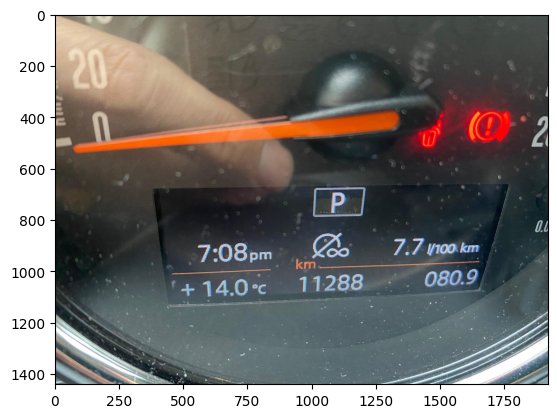

In [2]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_April 2021_229.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = copy.deepcopy(image)

# displaying image
plt.imshow(img)
plt.show()

In [3]:
# Adding custom options
custom_config = r"--psm 12"  # psm = page segmentation mode; 12 = Sparse text with OSD.

In [4]:
text = pytesseract.image_to_string(img, config=custom_config)
text

'Cua\n\n~~\n\n6 BO\n\n“gezil OV1+.\n\n2\n\nuly\n\n4d80-Z\n\n10\n\nLy OL f 7 A\n\n5°)\n\nSHERRIE,\n\n7\n\naa?\n'

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


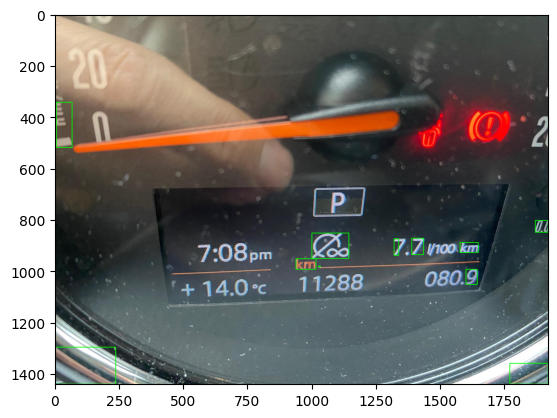

In [5]:
# draw boxes around things it recognized

THRESHOLD = 20  # 20 is a low threshold

d = pytesseract.image_to_data(img, output_type=Output.DICT, config=custom_config)
print(d.keys())

n_boxes = len(d["text"])
for i in range(n_boxes):
    if int(d["conf"][i]) > THRESHOLD:
        (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img, cmap="gray")
plt.show()

What did we learn? 

Tesseract seemingly doesn't work very well when trying to extract odometer values. 

### Try some image pre-processing

In [6]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# noise removal
def remove_noise(image):
    return cv2.medianBlur(image, 5)


# thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


# dilation
def dilate(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)


# erosion
def erode(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.erode(image, kernel, iterations=1)


# opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


# canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)


# skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(
        image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    return rotated


# template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


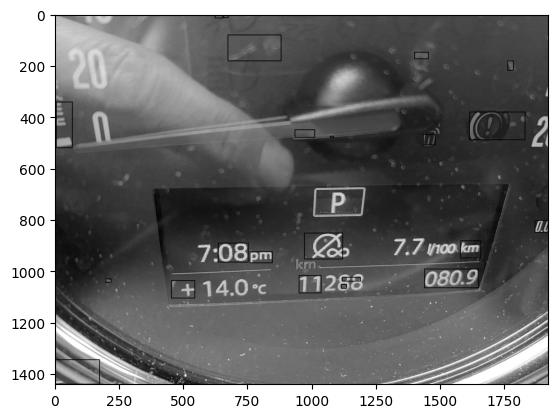

In [7]:
img_pp = get_grayscale(image)

d = pytesseract.image_to_data(img_pp, output_type=Output.DICT, config=custom_config)
print(d.keys())

n_boxes = len(d["text"])
for i in range(n_boxes):
    if int(d["conf"][i]) > THRESHOLD:
        (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
        img_pp = cv2.rectangle(img_pp, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img_pp, cmap="gray")
plt.show()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


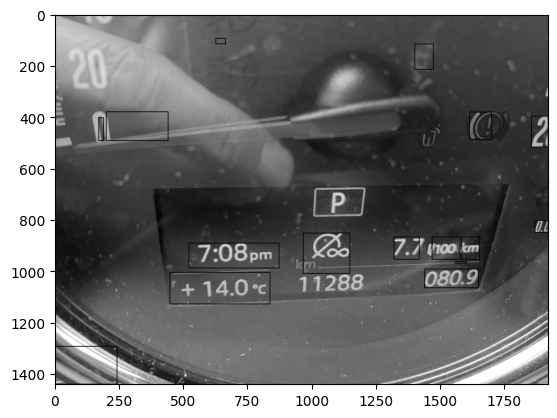

In [8]:
img_pp = remove_noise(image)
img_pp = get_grayscale(img_pp)

d = pytesseract.image_to_data(img_pp, output_type=Output.DICT, config=custom_config)
print(d.keys())

n_boxes = len(d["text"])
for i in range(n_boxes):
    if int(d["conf"][i]) > THRESHOLD:
        (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
        img_pp = cv2.rectangle(img_pp, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img_pp, cmap="gray")
plt.show()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


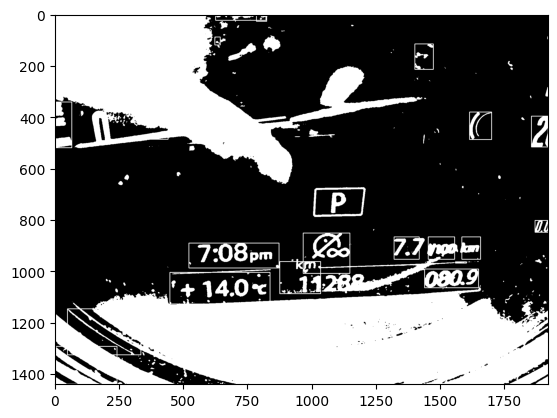

In [9]:
img_pp = remove_noise(image)
img_pp = get_grayscale(img_pp)
img_pp = thresholding(img_pp)

d = pytesseract.image_to_data(img_pp, output_type=Output.DICT, config=custom_config)
print(d.keys())

n_boxes = len(d["text"])
for i in range(n_boxes):
    if int(d["conf"][i]) > THRESHOLD:
        (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
        img_pp = cv2.rectangle(img_pp, (x, y), (x + w, y + h), (255, 255, 255), 2)

plt.imshow(img_pp, cmap="gray")
plt.show()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


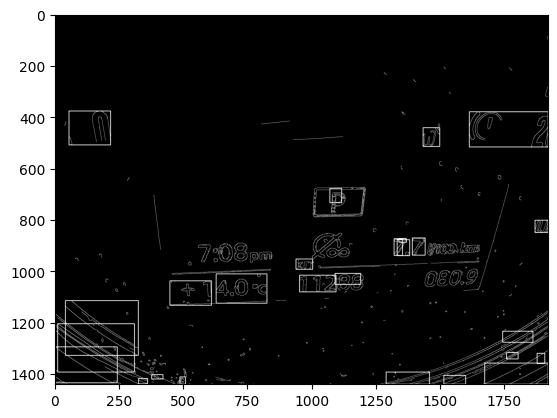

In [10]:
img_pp = remove_noise(image)
img_pp = get_grayscale(img_pp)
img_pp = canny(img_pp)

d = pytesseract.image_to_data(img_pp, output_type=Output.DICT, config=custom_config)
print(d.keys())

n_boxes = len(d["text"])
for i in range(n_boxes):
    if int(d["conf"][i]) > THRESHOLD:
        (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
        img_pp = cv2.rectangle(img_pp, (x, y), (x + w, y + h), (255, 255, 255), 2)

plt.imshow(img_pp, cmap="gray")
plt.show()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


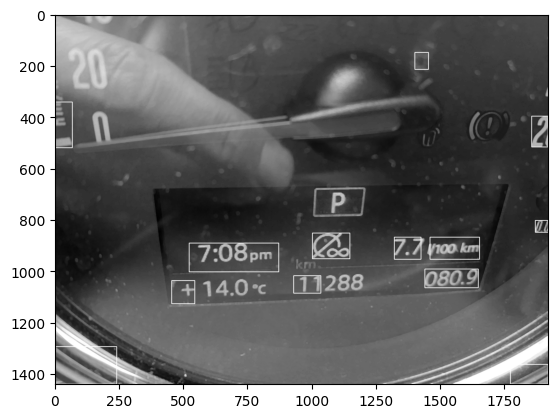

In [11]:
img_pp = remove_noise(image)
img_pp = get_grayscale(img_pp)
img_pp = opening(img_pp)

d = pytesseract.image_to_data(img_pp, output_type=Output.DICT, config=custom_config)
print(d.keys())

n_boxes = len(d["text"])
for i in range(n_boxes):
    if int(d["conf"][i]) > THRESHOLD:
        (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
        img_pp = cv2.rectangle(img_pp, (x, y), (x + w, y + h), (255, 255, 255), 2)

plt.imshow(img_pp, cmap="gray")
plt.show()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


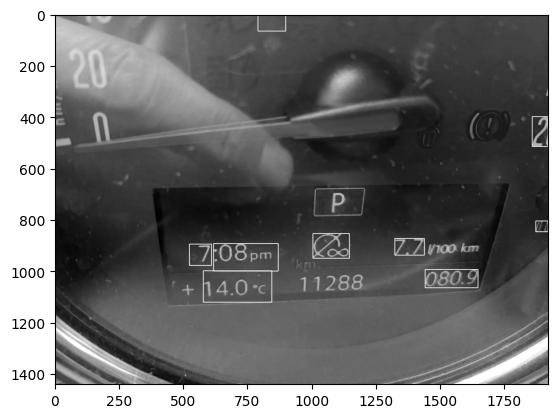

In [12]:
img_pp = remove_noise(image)
img_pp = get_grayscale(img_pp)
img_pp = erode(img_pp)

d = pytesseract.image_to_data(img_pp, output_type=Output.DICT, config=custom_config)
print(d.keys())

n_boxes = len(d["text"])
for i in range(n_boxes):
    if int(d["conf"][i]) > THRESHOLD:
        (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
        img_pp = cv2.rectangle(img_pp, (x, y), (x + w, y + h), (255, 255, 255), 2)

plt.imshow(img_pp, cmap="gray")
plt.show()

Basically, preprocessing makes the image better but the performance is still quite bad. 

## EAST (Efficient accurate scene text detector)

Took this code from https://medium.com/technovators/scene-text-detection-in-python-with-east-and-craft-cbe03dda35d5

Found the model (`frozen_east_text_detection.pb) from a dropbox link in [OpenCV_exra GitHub repo](https://github.com/opencv/opencv_extra/blob/8b8ac071c2b8a082e9a8b34239861a3c0b194049/testdata/dnn/download_models.py#L382) 

adapted the code a bit 

In [13]:
import os, sys
import numpy as np
import cv2
import time
import re
from imutils.object_detection import non_max_suppression


def east_detect(image, newSize=320):
    layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

    orig = image.copy()

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height: Should be multiple of 32
    (newW, newH) = (newSize, newSize)

    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))

    (H, W) = image.shape[:2]

    net = cv2.dnn.readNet(
        "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/eda/tesseract/frozen_east_text_detection.pb"
    )

    blob = cv2.dnn.blobFromImage(
        image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False
    )

    start = time.time()

    net.setInput(blob)

    (scores, geometry) = net.forward(layerNames)

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            # Set minimum confidence as required
            if scoresData[x] < 0.5:
                continue
            # compute the offset factor as our resulting feature maps will
            #  x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    boxes = non_max_suppression(np.array(rects), probs=confidences)
    # loop over the bounding boxes
    for startX, startY, endX, endY in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    print(time.time() - start)

    # Loop over the detected text regions and extract the text
    texts = []
    for box in boxes:
        (x, y, w, h) = box
        # Scale the coordinates back to the original dimensions
        x = int(x * rW)
        y = int(y * rH)
        w = int(w * rW)
        h = int(h * rH)
        # Crop the text region from the original image
        crop_img = orig[y : y + h, x : x + w]
        # Convert the cropped region to grayscale and apply thresholding
        gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        # Perform OCR using Tesseract
        text = pytesseract.image_to_string(
            thresh, config="--psm 11 -c tessedit_char_whitelist=0123456789"
        )
        # Print the extracted text
        text = re.findall(r"\d+", text)
        texts += text

    return orig, texts

0.12403202056884766


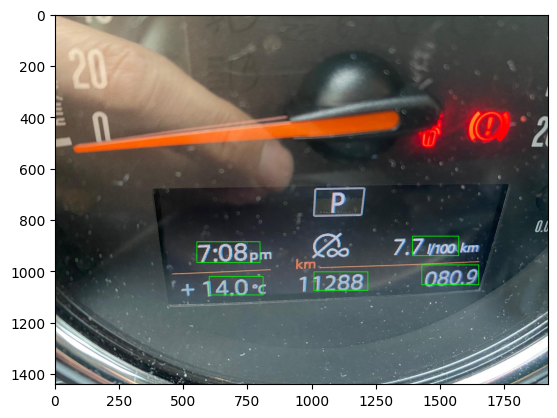

['080', '7', '1', '1288', '080', '9', '100', '080', '9']


In [14]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_April 2021_229.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image)

plt.imshow(out_image)
plt.show()

print(text)

0.12204694747924805


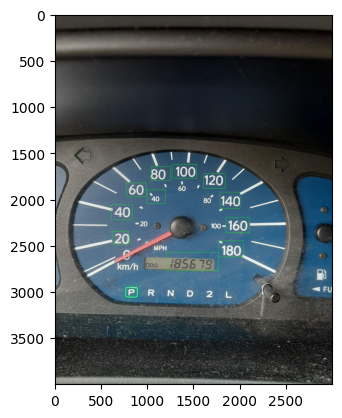

['100', '120', '80', '140', '100', '160', '180', '1', '2', '4', '9', '2', '7', '2', '4', '2', '7', '7', '0', '3', '7', '4', '42', '2', '43', '4', '1', '4', '2', '1', '89100', '120', '40', '140', '100160', '180', '2', '2', '2', '3', '2', '3', '8', '7', '4', '5', '1', '2', '4', '1', '7', '1', '6', '2', '8', '4', '4', '4', '4', '4', '2', '4', '5', '3', '8', '4', '7', '4', '3', '4', '3', '0', '4', '2', '4', '50', '2', '0', '3', '7', '4', '78', '8', '3', '0', '4', '2', '4', '2', '2', '4', '3', '4', '2', '2', '1', '7', '4', '7', '7', '5', '1', '4', '4', '4', '2', '4', '7', '1', '8', '0', '3', '4', '4', '7', '1', '7', '7', '4', '2', '8', '2', '14', '4', '15', '5', '7', '4', '74', '2', '7', '7', '7', '5', '7', '5', '9', '7', '4', '4', '8', '49', '4', '0', '3', '7', '8', '2', '1', '7', '27', '2']


In [15]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_April 2021_104.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image)

plt.imshow(out_image)
plt.show()

print(text)

0.13377809524536133


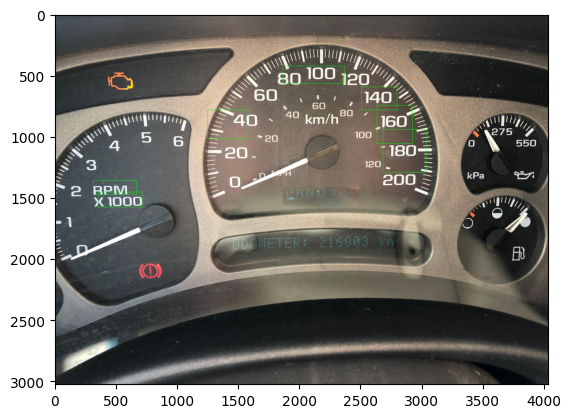

['100', '1', '4', '1', '8', '1', '24', '7', '18', '60', '3', '275', '2', '1000', '8', '5', '3', '22', '3', '3', '1', '75', '7', '550', '4', '4', '8', '4', '75', '7', '550', '5', '4', '4', '14', '4', '4', '550', '4', '4', '16', '3', '3', '97', '3', '407', '166', '100', '20', '1', '20', '120', '2']


In [16]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_April_2019_41.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image)

plt.imshow(out_image)
plt.show()

print(text)

0.1239309310913086


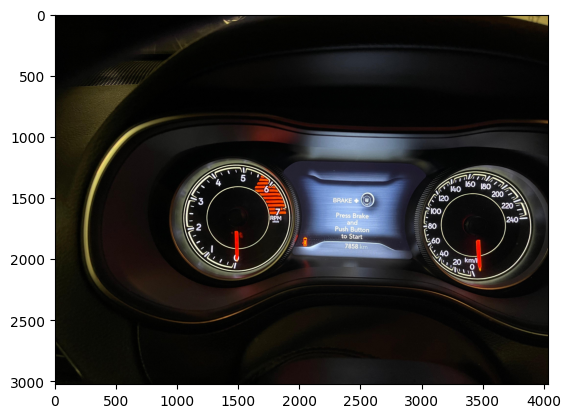

[]


In [17]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_BEU Completed_1.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image)

plt.imshow(out_image)
plt.show()

print(text)

Nope, not at all. None of them seem to work. 

It seems EAST is better at identifying where text/numbers are located compared to tesseract but tesseract still cant read the numbers. 

Looks like for the last two, the image quality is just too low.... which i realize can be fixed

1.3450558185577393


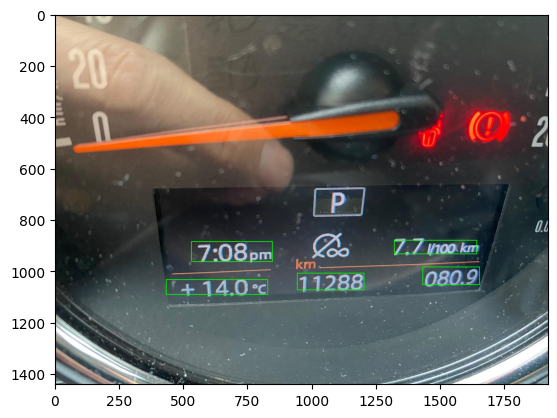

['00', '7', '11288', '080', '9', '140', '0', '11288']


In [18]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_April 2021_229.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image, newSize=1280)

plt.imshow(out_image)
plt.show()

print(text)

1.3268439769744873


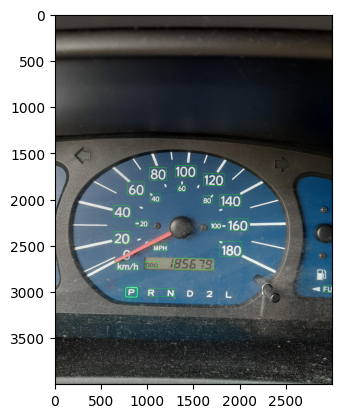

['75', '4', '2', '4', '3', '4', '0', '18', '7', '45', '9', '3', '5', '2', '7', '8', '4', '3', '5', '1', '7', '7', '7', '7', '7', '2', '7', '0', '3', '7', '4', '78', '8', '3', '0', '4', '4', '2', '4', '2', '4', '2', '3', '2', '2', '3', '8', '1', '4', '3', '7', '4', '1', '6', '8', '4', '8', '4', '4', '2', '4', '4', '7', '2', '5', '2', '7', '1', '8', '4', '5', '7', '7', '3', '4', '4', '3', '5', '4', '2', '1', '5', '0', '4', '4', '2', '8', '2', '1', '2', '5', '7', '4', '6', '1', '7', '4', '2', '2', '2', '4', '1', '15', '74', '1', '4', '45', '1', '8', '4', '7', '4', '2', '1', '4', '2', '7', '4', '3', '40', '4', '2', '4', '2', '7', '7', '7', '5', '100', '60', '120', '80', '140', '100', '160', '2', '000', '120', '40', '80', '140', '100160', '7', '80', '23', '3', '2', '1', '3', '4', '36', '5', '1', '7', '7', '4', '1', '8', '4', '47', '8', '8', '4', '4', '7', '2', '2', '5', '3', '9', '7', '4', '2', '8', '5', '4', '3', '2', '0', '3', '7', '8', '7', '42', '1', '0', '4', '4', '1', '2', '12', '74',

In [19]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_April 2021_104.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image, newSize=1280)

plt.imshow(out_image)
plt.show()

print(text)

1.2897491455078125


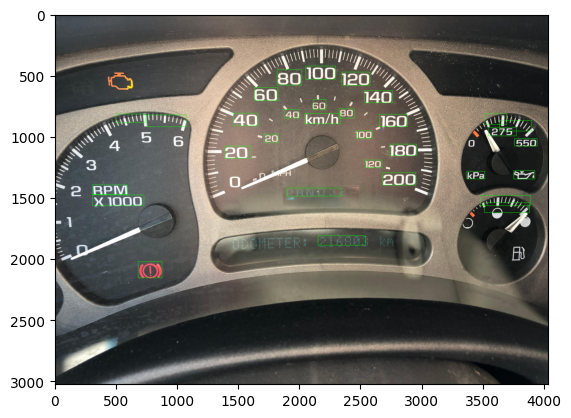

['4', '45', '1', '4', '4', '3', '4', '15', '8', '72', '5', '1', '1', '1', '5', '2', '5', '4', '24', '818', '2', '3', '4', '41', '3', '1', '28', '275', '4', '28', '7', '44', '40', '160', '00', '20', '10', '180', '120', '200', '8', '2', '7', '7', '7', '7', '46', '3', '3', '8', '1', '8', '275', '3', '4', '7', '22', '1', '4', '9', '1', '2', '21', '4', '7', '1', '4', '6', '7', '3', '1', '1', '6', '3', '53', '8', '8', '72', '3', '3', '4', '1', '48', '2', '2', '3', '163', '4', '1', '3', '8', '2', '0', '2', '4', '4', '4', '4', '3', '2', '5', '3', '74', '72', '4', '140', '3', '1607', '120', '7', '41', '8', '18', '48', '8', '4', '2', '8', '2', '7', '2', '2', '18', '2', '178', '275', '3', '24', '537', '4', '4', '4', '4', '4', '72', '2', '40', '20', '20', '0', '416', '2', '275', '1', '3', '2', '18', '1', '3', '275', '5', '4', '2', '2', '9', '2', '1', '4', '7', '4', '4', '8', '8', '4', '3', '4', '4', '4', '38', '1', '3', '2', '8', '4', '3', '3', '1', '4', '1', '4', '78', '6', '4', '3', '3', '3', '1

In [20]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_April_2019_41.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image, newSize=1280)

plt.imshow(out_image)
plt.show()

print(text)

1.2811660766601562


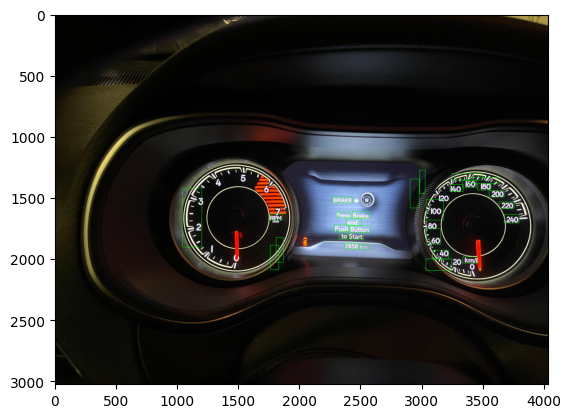

['2', '09', '240', '60', '0', '20', '240', '60', '0', '20', '0', '7', '240', '60', '0', '1', '20', '60', '10', '200', '200', '220', '240', '4', '200', '220', '240', '1', '60', '0', '2', '200', '220', '240', '40', '4', '60', '0', '240', '240', '0', '20', '20', '240', '0', '20', '60', '0', '7', '200', '220', '240', '200', '2', '09', '240', '60', '0', '0', '60', '0', '60', '0', '20', '60', '200', '09', '240', '60', '0', '20', '160', '7', '10', '200', '240', '20', '40', '60', '0']


In [21]:
image = cv2.imread(
    "/Users/roanraina/LOCAL/ICBC/ICBC-Odometer-Recognition/tmp/processed_BEU Completed_1.jpg"
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_image, text = east_detect(image, newSize=1280)

plt.imshow(out_image)
plt.show()

print(text)

So increasing the size of the image seems to improve EAST performance (but takes longer) across the board. This in turn seems to improve Tesseract's performance as shown in the first example. However, the remaining three examples still fail when it comes to transcribing the number. 